# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

## 1. Import necessary libraries and setup

In [1]:
# for timing how long it takes to import libraries
import time
t_lib_init = time.perf_counter()

import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths
from collections import Counter

t_lib_final = time.perf_counter()

print("time to import libraries:", str(t_lib_final - t_lib_init), "seconds")

time to import libraries: 1.7061227839999997 seconds


Define constants

In [2]:
# In TES-II-36a.tif there are 113 pixels per 100 nm
# In Challenge_1.jpg there are 92 pixels per 200nm = 46 pixels per 100 nm

t_pipe_init = time.perf_counter()

# nm_per_pixel = 100 / 46
# nm_per_pixel = 100 / 95
nm_per_pixel = 100 / 113
expected_radius = 100
print(str(nm_per_pixel), "nm per pixel")

0.8849557522123894 nm per pixel


## 2. Load input data and apply grayscale

We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Now each pixel will be 8 bits ranging from 0 (light) to 255 (dark).

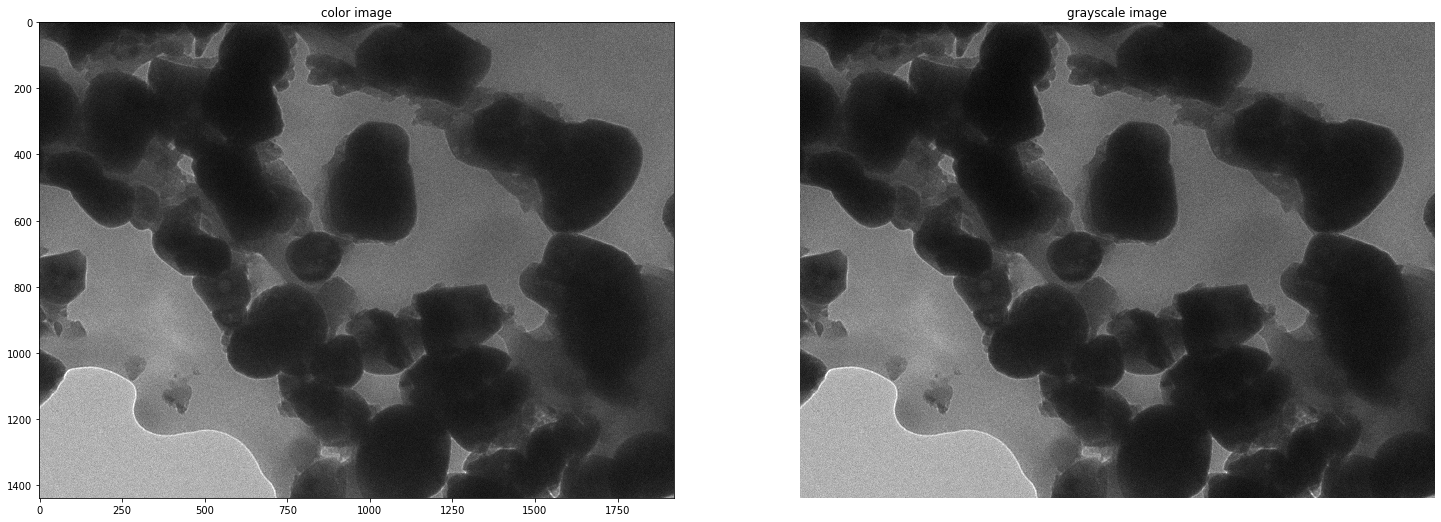

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME = "TES-36e-cropped.tif"
# IMAGE_NAME = "Challenge_2.png"

color_image = cv.imread(IMAGE_NAME)
gray_image = cv.cvtColor(color_image, cv.COLOR_BGR2GRAY)

# plot input and grayscale input
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
ax0.imshow(color_image)
ax0.set_title("color image");
# ax1.imshow(gray_image)
ax1.imshow(gray_image, cmap = plt.cm.gray) 
ax1.set_title("grayscale image");

In [4]:
# reshape images to be a ndarray of pixels
# color_pixels = color_image.reshape((color_image.shape[0] * color_image.shape[1], 3))
# gray_pixels = color_image.reshape((gray_image.shape[0] * gray_image.shape[1], 3))

## 3. Gaussian blur 

TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.

TODO: explain kernel matrix

Text(0.5, 1.0, 'kernel matrix size 5 by 5')

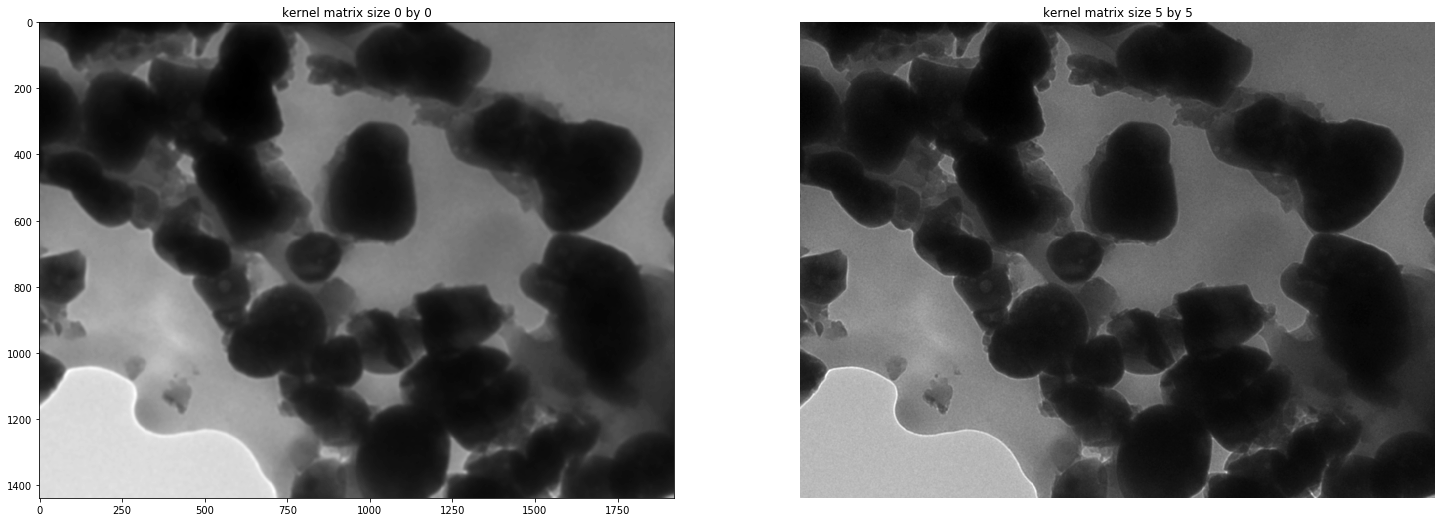

In [5]:
# apply gaussian blur
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
blur_1 = cv.GaussianBlur(gray_image, (0,0) ,cv.BORDER_DEFAULT) 
ax0.imshow(blur_1, cmap = plt.cm.gray) 
ax0.set_title("kernel matrix size 0 by 0")
blur_2 = cv.GaussianBlur(gray_image, (5,5) ,cv.BORDER_DEFAULT) # why only (0,0), (1,1), (5,5) work?
ax1.imshow(blur_2, cmap = plt.cm.gray)
ax1.set_title("kernel matrix size 5 by 5")

## 4. Binary Threshold 

Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.

TODO: explain OTSU's method

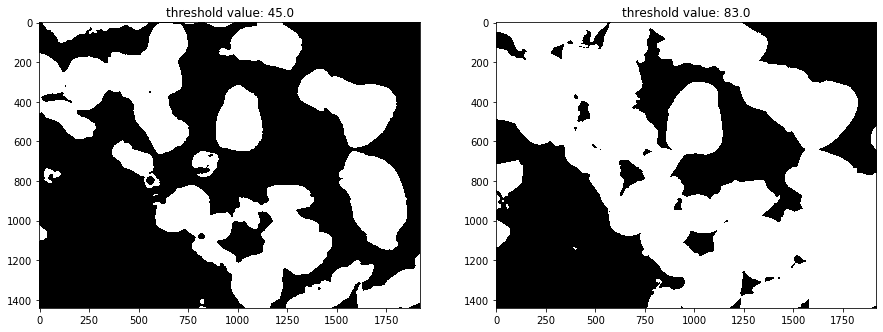

In [6]:
# binary threshold grayscale image
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
ret_1, thresh_1 = cv.threshold(blur_1, 45, 255, cv.THRESH_BINARY_INV)
ax0.imshow(thresh_1, cmap = plt.cm.gray)
ax0.set_title("threshold value: " + str(ret_1));

# auto binary threshold grayscale image with Otsu’s method
ret_2, thresh_2 = cv.threshold(blur_1, 120, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
ax1.imshow(thresh_2, cmap = plt.cm.gray)
ax1.set_title("threshold value: " + str(ret_2));

In [7]:
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
# ret_1, thresh_1 = cv.threshold(blur_1, 45, 255, cv.THRESH_BINARY_INV)
# ax0.imshow(thresh_1, cmap = plt.cm.gray)
# ax0.set_title("threshold value: " + str(ret_1));

# ret_2, thresh_2 = cv.threshold(blur_1, 50, 255, cv.THRESH_BINARY_INV)
# ax1.imshow(thresh_2, cmap = plt.cm.gray)
# ax1.set_title("threshold value: " + str(ret_2));

Calculate white to black ratio for all possible threshold values

In [8]:
# # store every threshold value's num white pixels / # num black pixels
# white_to_black = []

# # loop through all possible threshold values
# for i in range(256):
#     current_ret, current_thresh = cv.threshold(blur_1, i, 1, cv.THRESH_BINARY_INV)
#     # keep track of # white pixels
#     sum_white = 0
#     for row in current_thresh:
#         sum_white += np.sum(row)
#     white_to_black += [sum_white / current_thresh.size]

Plot white to black ratio for all possible threshold values

In [9]:
# # plot white to black ratio for all threshold values
# fig, axs = plt.subplots(1, 1, figsize=(7,7))
# axs.set_title("white to black ratio for all possible threshold values")
# axs.plot([x for x in range(256)], white_to_black)

## 5. Contours derived from sure background & foreground

Text(0.5, 1.0, 'dist transform')

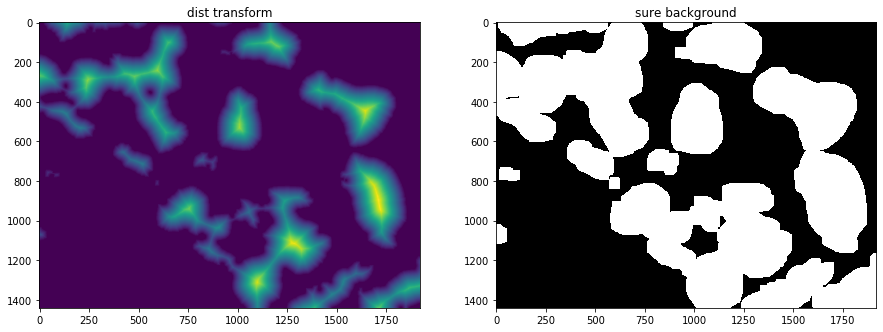

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# noise removal
kernel = np.ones((10,10),np.uint8)
opening = cv.morphologyEx(thresh_1,cv.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
ax1.imshow(sure_bg, cmap = plt.cm.gray)
ax1.set_title("sure background")

# Finding distance transform
# Lighter spots mean further away from contours
dist_transform = cv.distanceTransform(opening,cv.DIST_L2, 5)

ax0.imshow(dist_transform)
# ax0.imshow(unknown, cmap = plt.cm.gray)
ax0.set_title("dist transform")

### Threshold distance transform by the average value of intesities (TODO: unsure of where to use)

Get average value of intensities

In [11]:
# get sum of inensity values in distance transform
dist_sum = np.sum(dist_transform)
# get count of nonzero intensities in distance transform
nonzero_counter = Counter()
for row in dist_transform:
    nonzero_counter += Counter(row)
nonzero_count = len(dist_transform)*len(dist_transform[0]) - nonzero_counter[0.0]

print(dist_sum, nonzero_count)
average_value = dist_sum / nonzero_count
average_half = average_value / 2

# dist_norm = np.zeros((len(dist_transform), len(dist_transform[0])))

# for row in range(len(dist_transform)):
#     for col in range(len(dist_transform[0])):
#         if dist_transform[row][col] <= average_half and dist_transform[row][col] >= 2:
#             dist_norm[row][col] += average_half
#         else:
#             dist_norm[row][col] -= average_value
            
# ax1.imshow(dist_norm, cmap=plt.cm.gray)
# ax1.set_title("normalized distance transform")

41841790.0 1035615


Threshold distance transform at average value

In [12]:
# fig, ax0 = plt.subplots(1, 1, figsize=(10,10))
# ret, dist_average = cv.threshold(dist_transform, 0.4*dist_transform.max(), 255, 0)
# ax0.imshow(dist_average, cmap=plt.cm.gray)
# ax0.set_title("thresholded with 0.4 x max value")

### Contour Agglomerates

Text(0.5, 1.0, 'sure foreground')

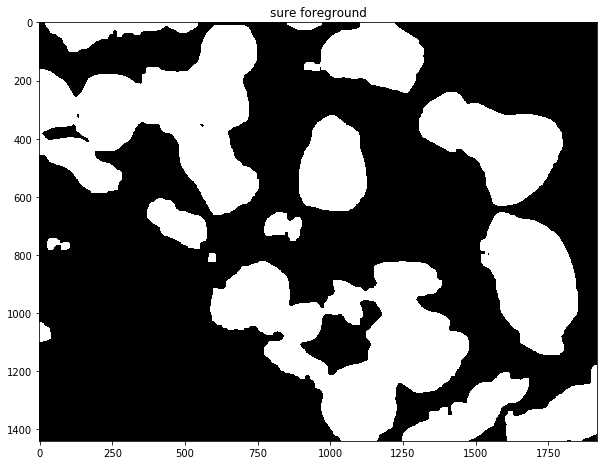

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret, sure_fg = cv.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
axs.imshow(sure_fg, cmap = plt.cm.gray)
axs.set_title("sure foreground")

Text(0.5, 1.0, 'unknown = background - foreground')

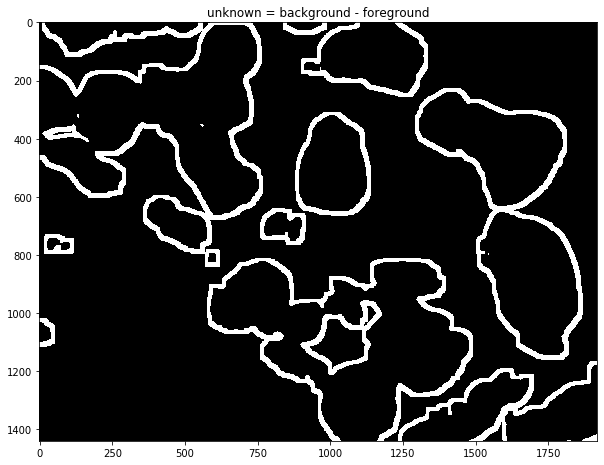

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap = plt.cm.gray)
axs.set_title("unknown = background - foreground")

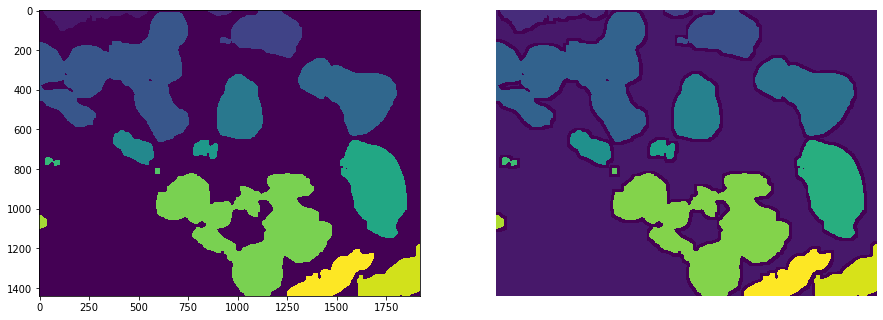

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
ax0.imshow(markers)

# If unknown's pixel is 255 (white), set corresponding pixel in markers to 0
markers[unknown==255] = 0
ax1.imshow(markers)

In [16]:
# copy input image
color_copy_1 = color_image.copy()

# TODO matrix multiplication optimization

for row in range(len(color_copy_1)):
    for col in range(len(color_copy_1[0])):
        if unknown[row][col] == 255:
            color_copy_1[row][col] = [255,0,0]

we set all boundary pixels to -1, then loop through all of them to make them red

then overlay red pixels on original image

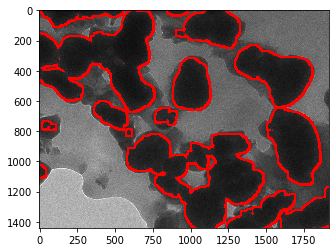

In [17]:
plt.imshow(color_copy_1)

### Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

Text(0.5, 1.0, 'sure foreground')

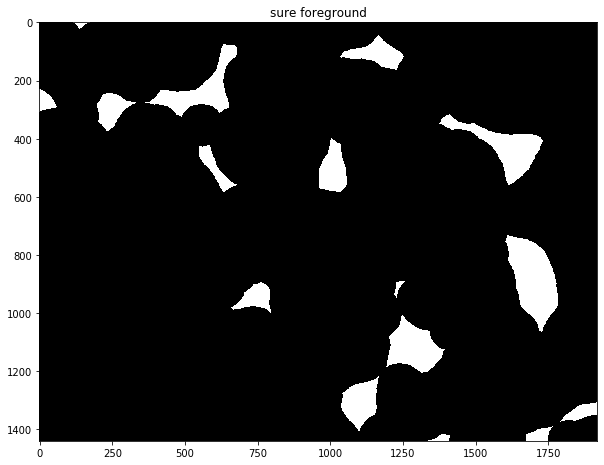

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret_2, sure_fg_2 = cv.threshold(dist_transform, 0.499999999*dist_transform.max(), 255, 0)
axs.imshow(sure_fg_2, cmap = plt.cm.gray)
axs.set_title("sure foreground")

In [19]:
# Finding unknown region
sure_fg_2 = np.uint8(sure_fg_2)
unknown_2 = cv.subtract(sure_bg, sure_fg_2)

## 6. Contours derived from Watershed algorithm

Markers pt.2 except this time they're derived from watershed instead of background - foreground

Text(0.5, 1.0, 'pre watershed markers')

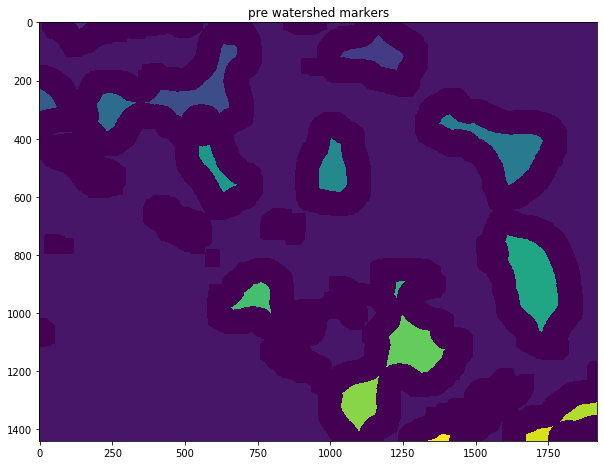

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Marker labelling
ret_2, pre_watershed_markers = cv.connectedComponents(sure_fg_2)
# Add one to all labels so that sure background is not 0, but 1
pre_watershed_markers = pre_watershed_markers+1
# Now, mark the region of unknown with zero
pre_watershed_markers[unknown_2==255] = 0

axs.imshow(pre_watershed_markers)
axs.set_title("pre watershed markers")

Run watershed algorithm from particle centers

Text(0.5, 1.0, 'watershed markers')

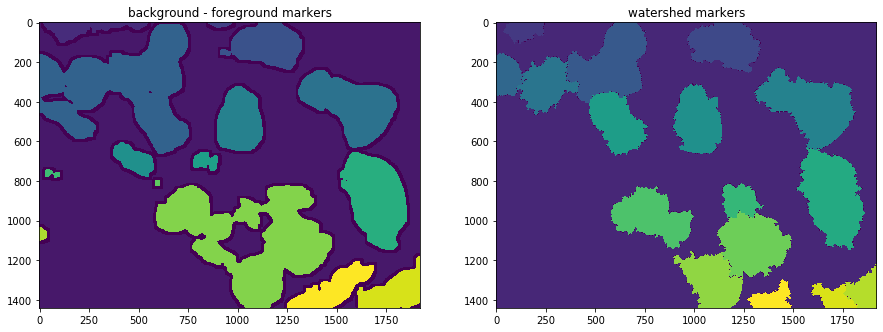

In [21]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# copy input image
watershed_color_copy = color_image.copy()

watershed_markers = cv.watershed(watershed_color_copy, pre_watershed_markers)
watershed_color_copy[pre_watershed_markers == -1] = [255,0,0]

ax0.imshow(markers)
ax0.set_title("background - foreground markers")
ax1.imshow(watershed_markers)
ax1.set_title("watershed markers")

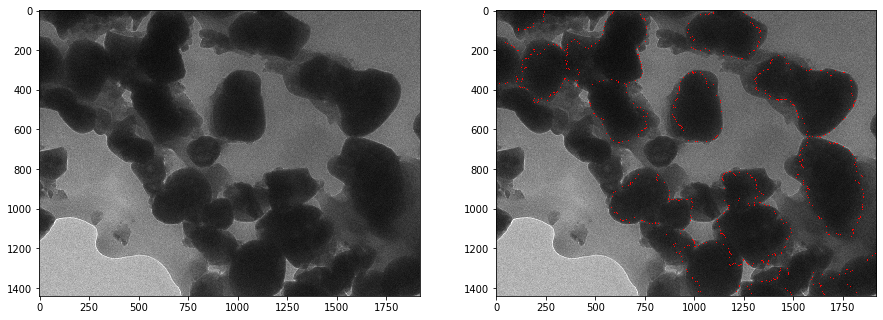

In [22]:
 fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

ax0.imshow(color_image)
ax1.imshow(watershed_color_copy)

First obtain contour pixels and get their colors

In [23]:
# pixels are appended as (col, row) in order to feed to cv.lines() later on

# copy input image
chords_color_copy = color_image.copy()

# dictionary mapping colors to their pixels
contour_colors = {}

contour_size = 0
# loop through pixels in watershed markers
for row in range(1, len(watershed_markers) - 1):
    for col in range(1, len(watershed_markers[0]) - 1):
        # if pixel not in background
        if watershed_markers[row][col] != 1:
            # get current pixel and its neighbours 
            current = watershed_markers[row][col]
            up = watershed_markers[row-1][col]
            down = watershed_markers[row+1][col]
            left = watershed_markers[row][col-1]
            right = watershed_markers[row][col+1]
            # if not surrounded by uniform pixels
            if ((up != current) or (down != current) or (left != current) or (right != current)):
                # if the right pixel is different
                if (right != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the right pixel is not in background, add it to the dictionary
                    if (right != 1):
                        if right not in contour_colors:
                            contour_colors[right] = [(col+1, row)]
                        else:
                            contour_colors[right] += [(col+1,row)]
                        chords_color_copy[row][col+1] = [255, 0, 0]
                        contour_size += 1
                        
                    chords_color_copy[row][col] = [255, 0, 0]
                    contour_size += 1
                    
                # if the down pixel is different
                elif (down != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the down pixel is not in background, add it to the dictionary
                    if (down != 1):
                        if down not in contour_colors:
                            contour_colors[down] = [(col, row+1)]
                        else:
                            contour_colors[down] += [(col,row+1)]
                        chords_color_copy[row+1][col] = [255, 0, 0]
                        contour_size += 1
                        
                    chords_color_copy[row][col] = [255, 0, 0]
                    contour_size += 1
                
                # if the up or left pixel is different than the current pixel and is not a border pixel
                elif (((up != 255) and (up != current)) or ((left != 255) and (left != current))):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                        
                    chords_color_copy[row][col] = [255, 0, 0]                    
                    contour_size += 1

In [24]:
# remove -1 key from contour_colors because it represents bad contours drawn by cv.watershed()
del contour_colors[-1]

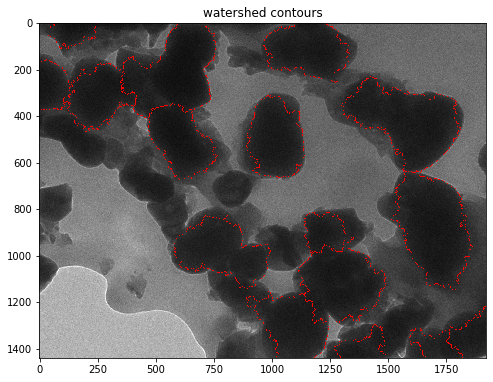

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(8,8))

axs.set_title("watershed contours")
axs.imshow(chords_color_copy)

In [26]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 26.886010232999997 seconds


## Find area of particlers
 to see if it is worth it to run watershed on the current threshold

In [27]:
t_area_init = time.perf_counter()

max_radius = 3*expected_radius
dist_transform_thresh = 0.25
while max_radius > (2*expected_radius):
    
    threshold, fg = cv.threshold(dist_transform, dist_transform_thresh*dist_transform.max(), 255, 0)
    
    # Finding unknown region
    fg = np.uint8(fg)
    unknown_2 = cv.subtract(sure_bg, fg)
    
    # Marker labelling
    threshold, pre_watershed_markers = cv.connectedComponents(fg)
    # Add one to all labels so that sure background is not 0, but 1
    pre_watershed_markers = pre_watershed_markers+1
    # Now, mark the region of unknown with zero
    pre_watershed_markers[unknown_2==255] = 0
    
    # copy input image
    watershed_color_copy = color_image.copy()

    watershed_markers = cv.watershed(watershed_color_copy, pre_watershed_markers)
    watershed_color_copy[pre_watershed_markers == -1] = [255,0,0]
    
    # dictionary mapping colors to their pixels
    particle_colors = {}

    # loop through pixels in watershed markers
    for row in range(1, len(watershed_markers) - 1):
        for col in range(1, len(watershed_markers[0]) - 1):
            # if pixel not in background
            if watershed_markers[row][col] != 1:
                # get current pixel and its neighbours 
                current = watershed_markers[row][col]
                # add current pixel to dictionary
                if current not in particle_colors:
                    particle_colors[current] = 1
                else:
                    particle_colors[current] += 1
                    
    # remove -1 key from particle_colors because it represents bad contours drawn by cv.watershed()
    del particle_colors[-1]
    
    # loop to adjust areas from number of pixels to nm^2
    max_radius = 0
    for particle in particle_colors:
        current_area = particle_colors[particle] * nm_per_pixel**2
        particle_colors[particle] = [current_area, (current_area/np.pi)**0.5]
        if (current_area/np.pi)**0.5 > max_radius:
            max_radius = (current_area/np.pi)**0.5
            
    print(dist_transform_thresh, max_radius)
            
    dist_transform_thresh += 0.05

0.25 230.41347553506517
0.3 230.09842852381198
0.35 230.58651386036445
0.39999999999999997 211.60993564640634
0.44999999999999996 207.60921609826366
0.49999999999999994 167.11884197998478


In [28]:
print(particle_colors)

{2: [12357.271516955127, 62.71715626608229], 4: [79866.86506382647, 159.44407398308277], 3: [51654.788941968836, 128.22725914939394], 5: [18226.172762158356, 76.1680443328351], 6: [40827.78604432611, 113.99950845905259], 7: [87098.4415381001, 166.50614106626276], 8: [50967.96930065002, 127.37192982407404], 9: [46039.62722217872, 121.05729429090947], 10: [87740.6218184666, 167.11884197998478], 11: [19289.68595817997, 78.35877578082324], 12: [58149.424387187726, 136.0497580238152], 13: [67034.22351006344, 146.07414574765474], 14: [48690.57874539902, 124.49374513874527], 15: [17451.64069230167, 74.53207203940431], 17: [13806.876027880024, 66.29377902177698], 16: [12996.319210588144, 64.3184024112114]}


In [29]:
t_area_final = time.perf_counter()

In [30]:
print("time to find areas:", str(t_area_final - t_area_init), "seconds")

time to find areas: 44.807308118 seconds


In [31]:
print(particle_colors)
print(max_radius)

{2: [12357.271516955127, 62.71715626608229], 4: [79866.86506382647, 159.44407398308277], 3: [51654.788941968836, 128.22725914939394], 5: [18226.172762158356, 76.1680443328351], 6: [40827.78604432611, 113.99950845905259], 7: [87098.4415381001, 166.50614106626276], 8: [50967.96930065002, 127.37192982407404], 9: [46039.62722217872, 121.05729429090947], 10: [87740.6218184666, 167.11884197998478], 11: [19289.68595817997, 78.35877578082324], 12: [58149.424387187726, 136.0497580238152], 13: [67034.22351006344, 146.07414574765474], 14: [48690.57874539902, 124.49374513874527], 15: [17451.64069230167, 74.53207203940431], 17: [13806.876027880024, 66.29377902177698], 16: [12996.319210588144, 64.3184024112114]}
167.11884197998478


In [32]:
print(dist_transform_thresh)

0.5499999999999999
